In [ ]:
## Created by Wentinn Liao

# Kalman Filter Research

In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Symlink Setup
import os

def ptpp(PATH: str) -> str: # Converts path to python path
    return PATH.replace('\\', '')

DRIVE_PATH = '/content/gdrive/My\ Drive/KF_RNN'
if not os.path.exists(ptpp(DRIVE_PATH)):
    %mkdir $DRIVE_PATH
SYM_PATH = '/content/KF_RNN'
if not os.path.exists(ptpp(SYM_PATH)):
    !ln -s $DRIVE_PATH $SYM_PATH
%cd $SYM_PATH

/content/gdrive/My Drive/KF_RNN


In [ ]:
!pip install numpy imageio matplotlib scikit-learn torch==2.0.0 tensordict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.5/986.5 kB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
#@title Configure Jupyter Notebook
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#@title Library Setup
import time
import json
import pickle
import math
import functools
import numpy as np
import scipy as sc
import sympy as sy
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import *
from argparse import Namespace
import random
import copy
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils as ptu
import torch.optim as optim
import torchdata
import torchvision
from torchvision import datasets, transforms
import tensordict
from tensordict import TensorDict

from model.linear_system import LinearSystem
from model.kf import KF
from model.rnn_kf import RnnKF

from infrastructure import utils
from infrastructure.train import *

# seed = 7
# torch.manual_seed(seed)
# random.seed(seed)
torch.set_default_dtype(torch.double)

dev_type = 'cuda'
if dev_type == 'xla':
    !pip install torch-xla cloud-tpu-client https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl
    import torch_xla
    import torch_xla.core.xla_model as xm

plt.rcParams['figure.figsize'] = (7.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# RNN Model Training

# Hyperparameter Sweep over LR and Momentum

In [ ]:
#@title Model Parameters
ModelArgs = Namespace(
    S_D = 6,
    I_D = 6,
    O_D = 4,
    SNR = 2.
)

In [ ]:
#@title Training Parameters
BaseTrainArgs = Namespace(
    # Dataset
    train_dataset_size = 1,
    valid_dataset_size = 100,
    train_sequence_length = 2000,
    valid_sequence_length = 200,

    # Batch sampling
    subsequence_length = 10,
    subsequence_initial_mode = "random",    # {"random", "replay_buffer"}
    sample_efficiency = 5,
    replay_buffer = 10,
    batch_size = 128,

    # Optimizer
    beta = 0.1,
    lr = 3e-4,
    momentum = 0.9,
    lr_decay = 0.99,
    optim_type = "Adam",                    # {"GD", "SGD", "SGDMomentum", "Adam"}
    l2_reg = 0.1,

    # Iteration
    iterations_per_epoch = 100,
    epochs = 20
)

In [ ]:
#@title Experiment Parameters
BaseExperimentArgs = Namespace(
    n_systems = 16,
    ensemble_size = 1,
    log_frequency = 5,
    print_frequency = 20
)

In [ ]:
#@title Experiment Configurations
import itertools

base_exp_name = 'SingleTrace'
output_dir = 'sweep'
output_fname = 'result'

optim_configs = [
    ('GD', dict()),
    ('SGDMomentum', dict()),
    ('Adam', {
        'lr': 1e-2
    })
]
system_configs = [
    ('', dict()),
    # ('ZeroObservation', {
    #     'H': torch.zeros(ModelArgs.O_D, ModelArgs.S_D)
    # })
]

lr_factors = torch.pow(2., torch.arange(-6., 6.5, 0.5)).tolist()
lr_system_mode = 'different'
momentums = [float(f'0.{t}') for t in range(10)]


result = {}
for (optim_config_name, optim_config), (system_config_name, system_config) in itertools.product(
    optim_configs,
    system_configs
):
    full_exp_name = f'{system_config_name}{optim_config_name}{base_exp_name}'
    full_output_dir = f'output/{output_dir}/Full{full_exp_name}'
    full_output_fname = f'{full_output_dir}/{output_fname}.pt'

    if os.path.exists(full_output_dir):
        with open(full_output_fname, 'rb') as fp:
            result[optim_config_name, system_config_name] = torch.load(fp, map_location=torch.device(dev_type))
    else:
        to_remove = set()
        temp_result = dict()
        for lr_factor, momentum in itertools.product(lr_factors, momentums):

            TrainArgs = copy.copy(BaseTrainArgs)
            TrainArgs.__dict__.update(optim_config)
            TrainArgs.optim_type = optim_config_name
            TrainArgs.momentum = momentum

            ExperimentArgs = copy.copy(BaseExperimentArgs)
            ExperimentArgs.exp_name = full_exp_name

            if optim_config_name == 'Adam':
                TrainArgs.lr *= lr_factor
                ExperimentArgs.exp_name += f'_lr{TrainArgs.lr}'
            else:
                TrainArgs.lr_factors = lr_factors
                TrainArgs.lr_system_mode = lr_system_mode
            if optim_config_name != 'GD':
                ExperimentArgs.exp_name += f'_momentum{TrainArgs.momentum}'
            ExperimentArgs.output_dir = output_dir

            Args = Namespace(
                model = ModelArgs,
                train = TrainArgs,
                experiment = ExperimentArgs
            )

            temp_result[optim_config_name, system_config_name, lr_factor, momentum] = run_experiment(
                Args,
                system_kwargs=system_config,
                output_mode='load',
                output_kwargs={'fname': output_fname}
            )[0 if optim_config_name == 'Adam' else lr_factors.index(lr_factor)]

            to_remove.add(f'output/{output_dir}/{ExperimentArgs.exp_name}')

        result[optim_config_name, system_config_name] = torch.stack([
            torch.stack([
                temp_result[optim_config_name, system_config_name, lr_f, m]
            for m in momentums])
        for lr_f in lr_factors])

        TrainArgs = copy.copy(BaseTrainArgs)
        TrainArgs.__dict__.update(optim_config)
        TrainArgs.optim_type = optim_config_name
        TrainArgs.lr_factors = lr_factors
        TrainArgs.momentum = momentums

        ExperimentArgs = copy.copy(BaseExperimentArgs)
        ExperimentArgs.exp_name = full_exp_name

        Args = Namespace(
            model = ModelArgs,
            train = TrainArgs,
            experiment = ExperimentArgs
        )

        %mkdir -p $full_output_dir
        with open(f'{full_output_dir}/hparams.json', 'w') as fp:
            json.dump(utils.toJSON(Args), fp, indent=4)
        with open(full_output_fname, 'wb') as fp:
            torch.save(result[optim_config_name, system_config_name], fp)

        for dir in to_remove - {full_output_dir}:
            %rm -rf $dir

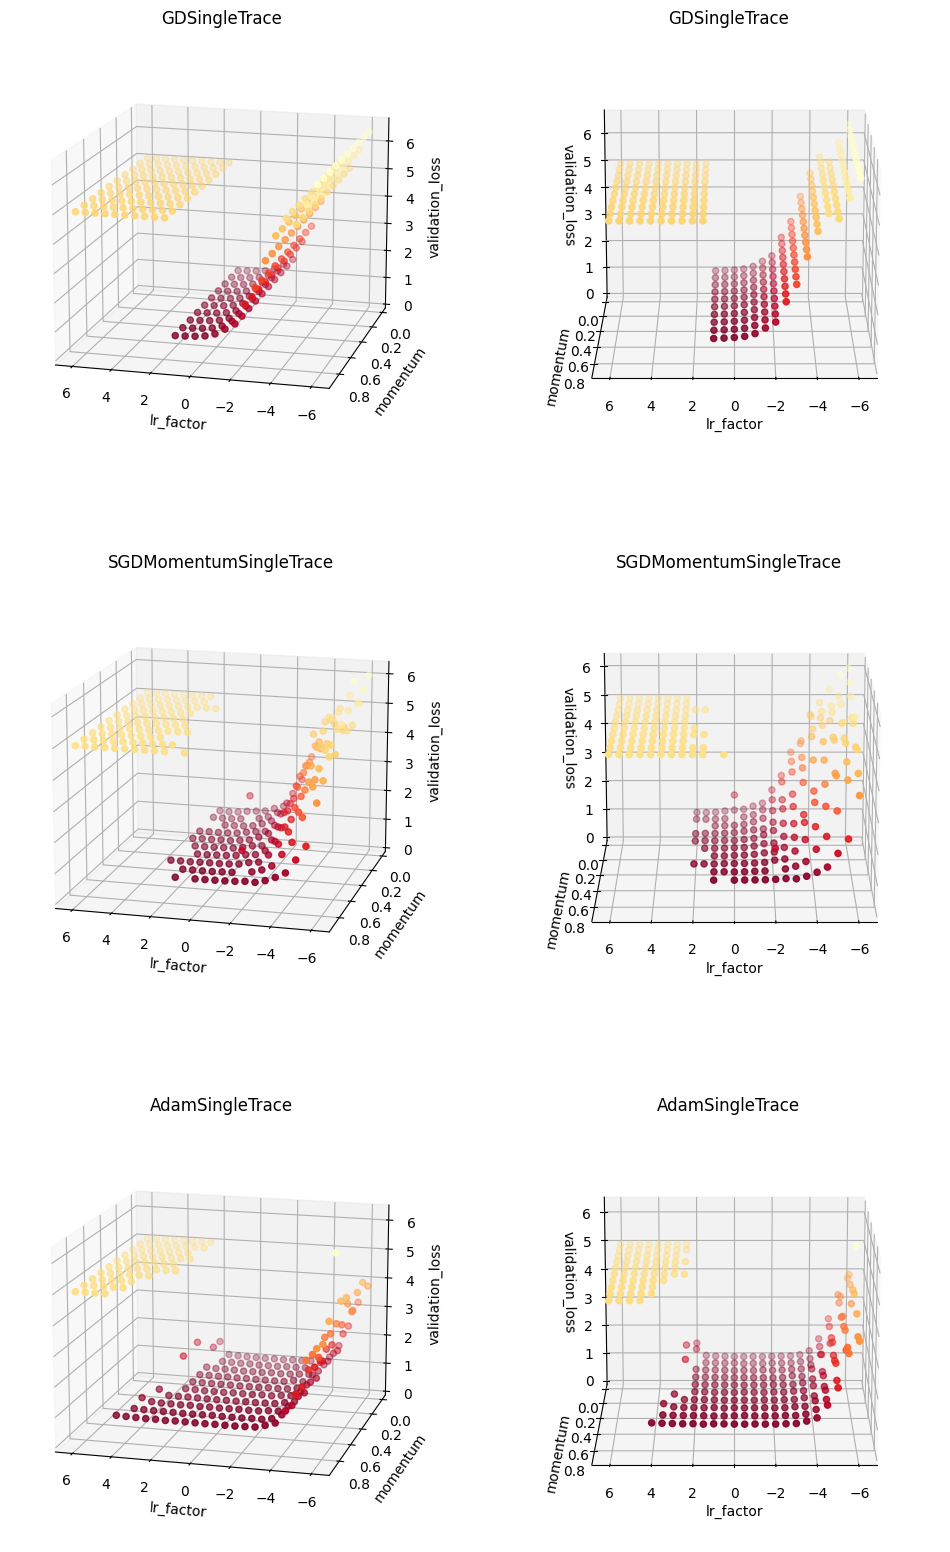

In [ ]:
H, W = len(optim_configs), len(system_configs)
plt.rcParams['figure.figsize'] = (12.0, 20.0)
fig, axs = plt.subplots(H, 2 * W, subplot_kw={'projection': '3d'})

tail = 10
c = 5.
for (h, (optim_config_name, _)), (w, (system_config_name, _)) in itertools.product(
    enumerate(optim_configs),
    enumerate(system_configs)
):
    exp_name = system_config_name + optim_config_name + base_exp_name
    r = result[optim_config_name, system_config_name]

    training_loss, overfit_loss, validation_loss, irreducible_loss = (r[k].detach().cpu() for k in (
        'training_loss',
        'overfit_loss',
        'validation_loss',
        'irreducible_loss'
    ))

    normalized_validation_loss = torch.mean(validation_loss[:, :, :, :, -tail:], dim=-1) / irreducible_loss
    mean_normalized_validation_loss = torch.nan_to_num(torch.mean(normalized_validation_loss, dim=(2, 3)), nan=c)
    mean_normalized_validation_loss[mean_normalized_validation_loss > 10000.] = c

    lr_factors_mesh, momentums_mesh = torch.meshgrid(torch.log2(torch.DoubleTensor(lr_factors)), torch.DoubleTensor(momentums))

    # View 1
    axs[h, 2 * w].view_init(elev=15., azim=105.)
    axs[h, 2 * w].scatter(lr_factors_mesh, momentums_mesh, mean_normalized_validation_loss, s=20, c=mean_normalized_validation_loss, cmap=plt.cm.YlOrRd_r)

    axs[h, 2 * w].set_xlabel('lr_factor')
    axs[h, 2 * w].set_ylabel('momentum')
    axs[h, 2 * w].set_zlim(bottom=0)
    axs[h, 2 * w].set_zlabel('validation_loss')
    axs[h, 2 * w].set_title(exp_name)

    # View 2
    axs[h, 2 * w + 1].view_init(elev=15., azim=90.)
    axs[h, 2 * w + 1].scatter(lr_factors_mesh, momentums_mesh, mean_normalized_validation_loss, s=20, c=mean_normalized_validation_loss, cmap=plt.cm.YlOrRd_r)

    axs[h, 2 * w + 1].set_xlabel('lr_factor')
    axs[h, 2 * w + 1].set_ylabel('momentum')
    axs[h, 2 * w + 1].set_zlim(bottom=0)
    axs[h, 2 * w + 1].set_zlabel('validation_loss')
    axs[h, 2 * w + 1].set_title(exp_name)
plt.show()

In [ ]:
H, W = len(optim_configs), len(system_configs)
plt.rcParams['figure.figsize'] = (12.0, 20.0)
fig, axs = plt.subplots(H, W)

for h, (optim_config_name, _) in enumerate(optim_configs):
    for w, (system_config_name, _) in enumerate(system_configs):
        exp_name = system_config_name + optim_config_name + base_exp_name

        r = result[optim_config_name][system_config_name]

        training_loss, overfit_loss, validation_loss, irreducible_loss = (r[k].detach().cpu() for k in (
            'training_loss',
            'overfit_loss',
            'validation_loss',
            'irreducible_loss'
        ))

        x = torch.arange(training_loss.shape[-1], dtype=float)
        irreducible_loss = irreducible_loss[:, :1]

        axs[h, w].plot(x, torch.ones_like(x), linestyle='--', linewidth=0.5, color='black', label='normalized irreducible_loss')
        for lname in ('training_loss', 'overfit_loss', 'validation_loss'):
            loss = torch.mean(eval(lname), dim=1)
            normalized_loss = loss / irreducible_loss

            mean_normalized_loss = torch.mean(normalized_loss, dim=0)
            min_normalized_loss = torch.min(normalized_loss, dim=0)
            max_normalized_loss = torch.max(normalized_loss, dim=0)

            axs[h, w].plot(x, min_normalized_loss.values, linewidth=0.5, label=f'mean normalized {lname}')
        #     plt.fill_between(x, min_normalized_loss, max_normalized_loss, alpha=0.2)

        axs[h, w].set_xlabel('Batch')
        axs[h, w].set_ylabel('Normalized Loss')
        axs[h, w].set_title(exp_name)
        # axs[h, w].legend()
plt.show()

In [ ]:
H, W = len(optim_configs), len(system_configs)
plt.rcParams['figure.figsize'] = (12.0, 20.0)
fig, axs = plt.subplots(H, W)

tail = 10
cutoff = 100
for h, (optim_config_name, _) in enumerate(optim_configs):
    for w, (system_config_name, _) in enumerate(system_configs):
        exp_name = system_config_name + optim_config_name + base_exp_name

        r = result[optim_config_name][system_config_name]

        training_loss, overfit_loss, validation_loss, irreducible_loss = (r[k].detach().cpu() for k in (
            'training_loss',
            'overfit_loss',
            'validation_loss',
            'irreducible_loss'
        ))

        x = torch.arange(cutoff, training_loss.shape[-1], dtype=float)

        axs[h, w].plot(x, torch.ones_like(x), linestyle='--', linewidth=1., color='black', label='normalized irreducible_loss')
        normalized_overfit_loss = overfit_loss / irreducible_loss[:, :, None]
        normalized_validation_loss = validation_loss / irreducible_loss[:, :, None]

        N = len(irreducible_loss)
        for n, (overfit_loss, validation_loss) in list(enumerate(zip(normalized_overfit_loss, normalized_validation_loss)))[::2]:
            mean_overfit_loss = torch.mean(overfit_loss, dim=0)[cutoff:]
            mean_validation_loss = torch.mean(validation_loss, dim=0)[cutoff:]

            c = color(n, scale=N)
            axs[h, w].plot(x, mean_overfit_loss, linewidth=1., color=c, label=f'Experiment {n}')
            axs[h, w].plot(x, mean_validation_loss, linewidth=1., color=c)
            axs[h, w].fill_between(x, mean_overfit_loss, mean_validation_loss, alpha=0.1, color=c)

        axs[h, w].set_xlabel('Batch')
        axs[h, w].set_ylabel('Normalized Loss')
        axs[h, w].set_title(f'{exp_name} - Normalized Overfit Loss')
        # axs[h, w].legend()
plt.show()

In [ ]:
H, W = len(optim_configs), len(system_configs)
plt.rcParams['figure.figsize'] = (12.0, 20.0)
fig, axs = plt.subplots(H, W)

tail = 10
for h, (optim_config_name, _) in enumerate(optim_configs):
    for w, (system_config_name, _) in enumerate(system_configs):
        exp_name = system_config_name + optim_config_name + base_exp_name

        r = result[optim_config_name][system_config_name]

        training_loss, overfit_loss, validation_loss, irreducible_loss = (r[k].detach().cpu() for k in (
            'training_loss',
            'overfit_loss',
            'validation_loss',
            'irreducible_loss'
        ))

        normalized_overfit_loss = overfit_loss / irreducible_loss[:, :, None]
        normalized_validation_loss = validation_loss / irreducible_loss[:, :, None]

        irreducible_, indices = torch.sort(irreducible_loss[:, 0])
        tail_ = torch.mean(normalized_overfit_loss[:, :, -tail:], dim=-1)
        mean_ = torch.mean(tail_, dim=1)[indices]
        std_ = torch.std(tail_, dim=1)[indices]
        min_ = tail_[torch.arange(len(mean_)), torch.argmin(tail_, dim=1)][indices]
        max_ = tail_[torch.arange(len(mean_)), torch.argmax(tail_, dim=1)][indices]


        axs_twinx = axs[h, w].twinx()
        axs[h, w].plot(irreducible_, torch.zeros_like(mean_), linewidth=1., linestyle='--', marker='.', color='black', label=f'Mean loss')
        axs_twinx.plot(irreducible_, mean_, linewidth=1., marker='.', color='blue', label='mean overfit loss')

        axs[h, w].plot(irreducible_, min_ - mean_, linewidth=0.5, marker='.', color='turquoise')
        # axs[h, w].plot(mean_, max_ - mean_, linewidth=0.5, marker='.', color='turquoise')

        axs[h, w].fill_between(irreducible_, min_ - mean_, max_ - mean_, color='aquamarine', alpha=0.2, label='min-max')
        axs[h, w].fill_between(irreducible_, -std_, std_, color='aquamarine', alpha=0.5, label='1 std')

        axs[h, w].set_xlabel('Normalized mean loss per system')
        axs[h, w].set_title(f'{exp_name}')
        # axs[h, w].legend()
plt.show()